In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
def is_unfreeze(learner):
    '''
    Determines whether the next-to-last layer in the model is set to unfreeze or freeze
    '''
    c = 0
    for each in list(learner.model[-2][0].parameters()):
        if each.requires_grad: c += 1   
    if c == len(list(learner.model[-2][0].parameters())):
        return True 
    else:
        return False



def find_optimal_lr(learner, noise=3, show_df=None, show_min_values=False):
    loss = np.array(learner.recorder.losses)
    loss_grad = np.gradient(loss)   
    # Transform lrs list to np array
    lrs = np.array(learner.recorder.lrs, dtype='float32')

    # Create a DataFrame with the data
    data = {'loss': loss.T, 'loss_grad': loss_grad.T, 'lrs': lrs.T}
    df = pd.DataFrame(data, columns=['loss', 'loss_grad', 'lrs', 'min_loss', 'max_loss', 'min_grad', 'max_grad'])

    # Populate "min" and "max" columns for loss and gradient values filtering the noise with argrelextrema.     
    from scipy.signal import argrelextrema

    #********
    # IMPORTANT: n filters noise (sharp spikes in the data). Higher n value filters noise more aggressively. 
    # n = 3 seems to work best
    n=noise    
    #********

    df.min_loss = df.iloc[argrelextrema(df.loss.values, np.less_equal, order=n)[0]]['loss']
    df.max_loss = df.iloc[argrelextrema(df.loss.values, np.greater_equal, order=n)[0]]['loss']
    df.min_grad = df.iloc[argrelextrema(df.loss_grad.values, np.less_equal, order=n)[0]]['loss_grad']
    df.max_grad = df.iloc[argrelextrema(df.loss_grad.values, np.greater_equal, order=n)[0]]['loss_grad']

    # Optional: Display dataframe if show_df=True
    if show_df == 'head': print(df.head(50)) 
    elif show_df == 'tail': print(df.tail(50))     

    # Plot losses and loss gradients against lr values
    plt.figure(figsize=[8, 5])
    #figs, ax = plt.subplots(1,1)
    ax = plt.gca()
    color_loss = 'blue'
    color_grad = 'orange'
    color_green = 'green'
    color_red = 'red'

    ax.xaxis.grid(True)
    ax.set_ylabel('Loss')
    ax.set_title('Learn Rate Finder')
    ax.tick_params(axis='y', labelcolor=color_loss)
    ax.semilogx(df.lrs, df.loss, c=color_loss, label='loss')

    # Define variable vertical size of the plot window, depending on the graph shape
    u_limit = max(df.loss.loc[(df.lrs < 0.1)].max(), 250)*2    
    ax.set_ylim([-200, u_limit])

    # Plot resulting line graphs
    ax2 = ax.twinx()
    ax2.set_ylabel('loss', color= color_grad)
    ax2.semilogx(df.lrs, df.loss_grad, c = color_grad, label='loss_grad')
    ax2.tick_params(axis='y', labelcolor = color_grad)

    # plot inflection points
    ax.scatter(df.lrs, df.min_loss, c = color_red, label='min_loss')    
    ax2.scatter(df.lrs, df.min_grad, c = color_red, label='min_grad')    
    if show_min_values:
        ax.scatter(df.lrs, df.max_loss, c = color_green, label='max_loss')
        ax2.scatter(df.lrs, df.max_grad, c = color_green, label='max_grad') 

    # Legends
    plt.LogFormatter(labelOnlyBase=False)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3, fancybox=True, shadow=True)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 0.9), ncol=3, fancybox=True, shadow=True)
    plt.show()

    # Display resulting lr values, format varies depending of te state of the model's next-to-last layer ggroup: set to freeze or unfreeze    
    if is_unfreeze(learner):
        # Yellow min_grad graph
        rev_tru_idx = df.min_grad.notna()[::-1]   
        optimun_lr_upper_bound_g = df.lrs.iloc[rev_tru_idx.idxmax()] 
        rev_tru_idx[rev_tru_idx.idxmax()] = np.NaN      
        optimun_lr_lower_bound_1_g = df.lrs.iloc[rev_tru_idx.idxmax()]
        rev_tru_idx[rev_tru_idx.idxmax()] = np.NaN      
        optimun_lr_lower_bound_2_g = df.lrs.iloc[rev_tru_idx.idxmax()] 

        # Blue lass graph
        rev_tru_idx_loss = df.min_loss.notna()[::-1]   
        optimun_lr_upper_bound_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()] 
        rev_tru_idx_loss[rev_tru_idx_loss.idxmax()] = np.NaN      
        optimun_lr_lower_bound_1_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()]
        rev_tru_idx_loss[rev_tru_idx_loss.idxmax()] = np.NaN      
        optimun_lr_lower_bound_2_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()] 

        # Print results and return choices of lr slice
        print('Model set to: "unfreeze" or "freeze_to:"')      
        data = {'*Gradient - Orange Graph*' : [optimun_lr_upper_bound_g, optimun_lr_lower_bound_1_g, optimun_lr_lower_bound_2_g], 
          '*Loss - Blue Graph*' : [optimun_lr_upper_bound_l, optimun_lr_lower_bound_1_l, optimun_lr_lower_bound_2_l]}
        prdf = pd.DataFrame(data, index = ['First choice lr:', 'Second choice lr:', 'Third choice lr:' ])
        pd.options.display.float_format = '{:.10E}'.format

        print(prdf)

        return optimun_lr_lower_bound_1_g, optimun_lr_upper_bound_g

    else:

        optimun_lr_upper_bound = df.lrs.iloc[df.min_grad.notna()[::-1].idxmax()]
        optimun_lr_lower_bound = df.lrs.iloc[df.min_loss.notna()[::-1].idxmax()]/10
        # Print results and return optimal lr
        print('Model set to "freeze":')
        print('  Optimun lr: {:.10E} '.format(optimun_lr_upper_bound))
        print('  Min loss divided by 10: {:.10E}'.format(optimun_lr_lower_bound))
        return optimun_lr_upper_bound 

In [4]:
path=Path('/storage/planet')

In [5]:
path.ls()

[PosixPath('/storage/planet/train_v2.csv'),
 PosixPath('/storage/planet/train-jpg'),
 PosixPath('/storage/planet/.ipynb_checkpoints')]

! 7za -bd -y -so x {path}/train.7z | tar xf - -C {path.as_posix()}

In [6]:
fnames=get_image_files(path/'train-jpg')

In [7]:
len(fnames);
fnames[0]

PosixPath('/storage/planet/train-jpg/train_24474.jpg')

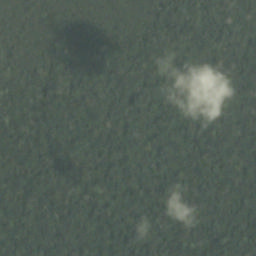

In [8]:
open_image(fnames[0])

In [9]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [16]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [11]:
doc(MultiCategoryList)

In [12]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [13]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [27]:
data=(MultiCategoryList.from_csv(path,'train_v2.csv')
.split_by_rand_pct(0.2)
.label_from_df(label_delim=' ')
     .transform(get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.), size=128))

Exception: It's not possible to apply those transforms to your dataset:
 Not implemented: you can't apply transforms to this type of item (MultiCategory)

In [21]:
data=data.databunch()

In [14]:
data.show_batch()

AttributeError: 'MultiCategoryList' object has no attribute 'show_xys'

In [23]:
acc_02 = partial(accuracy_thresh, thresh=0.2)

In [24]:
learn=cnn_learner(data,models.resnet18,metrics=acc_02)

In [25]:

learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: Expected 4-dimensional input for 4-dimensional weight 64 3 7 7, but got 2-dimensional input of size [64, 16] instead